In [21]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model, set_random_seed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Number of Duplicates: 0


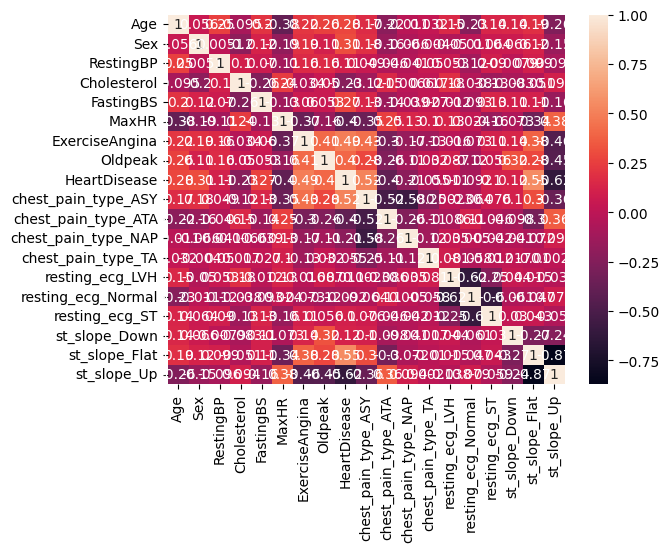

In [22]:
# IMPORTING AND READING IN DATA


# Import csv file
with open('heart.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')

# Read in data
df = pd.read_csv('heart.csv')



# PREPROCESSING AND DATA CLEANING


# Printing number of duplicates (equal to 0 here)
print("Number of Duplicates:", df.duplicated().sum())

# Male/Female encoding
labelencoder = LabelEncoder()
df['Sex'] = labelencoder.fit_transform(df['Sex'])

# EhestPainType encoding (ATA, NAP, ASY, TA)
df = pd.get_dummies(df, columns=['ChestPainType'], prefix='chest_pain_type')

# RestingECG encoding (Normal, ST, LVH)
df = pd.get_dummies(df, columns=['RestingECG'], prefix='resting_ecg')

# ExerciseAngina encoding (No, Yes)
labelencoder = LabelEncoder()
df['ExerciseAngina'] = labelencoder.fit_transform(df['ExerciseAngina'])

# ST_Slope encoding (Up, Flat, Down)
df = pd.get_dummies(df, columns=['ST_Slope'], prefix='st_slope')

# Correlation matrix heatmap
sns.heatmap(df.corr(), annot=True)

# Dropping RestingBP and RestingEGC because of low correlation with HeartDisease
X = df.drop(['HeartDisease', 'RestingBP', 'resting_ecg_LVH', 'resting_ecg_Normal', 'resting_ecg_ST'], axis=1)
y = df['HeartDisease']

# Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results list for future analysis
precision = []
recall = []
accuracy = []

<Axes: >

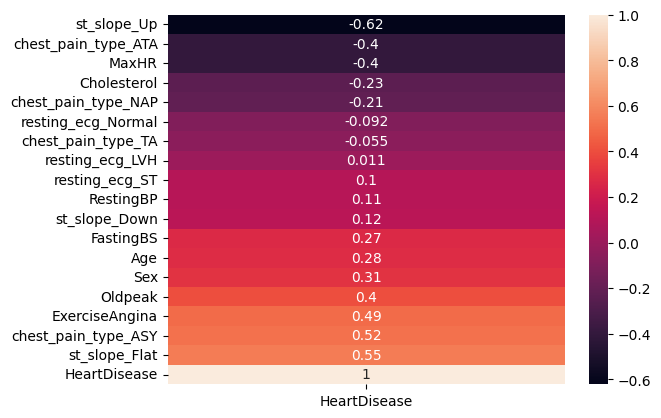

In [23]:
# Correlations relative to HeartDisease
sns.heatmap(df.corr()['HeartDisease'].sort_values().to_frame(), annot=True)

In [ ]:
# kNN MODEL
list_RMSE = []

for k in range (1, 50):
  knn_cv = KNeighborsRegressor(n_neighbors=k)
  neg_mse_scores = cross_val_score(knn_cv, X_train_scaled, y_train, cv=5,
  scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-neg_mse_scores)
  
  # Print each cv score (accuracy) and average them
  print(rmse_scores)
  print('cv_scores mean (RMSE): ', np.mean(rmse_scores))

  # Append to list of RMSE scores and average RMSE scores
  list_RMSE.append(np.append(rmse_scores, np.mean(rmse_scores)))

print(list_RMSE)

# Plot
plt.plot(range(1, 50), list_RMSE)
plt.xlabel('number of neighbours (k)')
plt.ylabel('RMSE')
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average'], loc='upper right')
plt.show()

# Best k by analysing the plot
best_k = 11

# Index starts at 0, so we add 1
print("Best k is: ", best_k + 1)

best_knn = KNeighborsRegressor(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

y_pred = best_knn.predict(X_test_scaled)

# Accuracy (we add .round() because we want to round the values to 0 or 1)
print("Accuracy:", accuracy_score(y_test, y_pred.round()))

# Precision and recall
print("Precision:", precision_score(y_test, y_pred.round()))
print("Recall:", recall_score(y_test, y_pred.round()))
print("RMSE (average):", list_RMSE[best_k][5])


# Results append
precision.append(precision_score(y_test, y_pred.round()))
recall.append(recall_score(y_test, y_pred.round()))
accuracy.append(accuracy_score(y_test, y_pred.round()))

In [25]:
# RANDOM FOREST MODEL

# Declaring variables
rf = RandomForestClassifier(random_state=42)
n_estimators = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]     # Number of trees in random forest
max_depth = [10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]    # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 15, 20, 25]     # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 3, 4]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]    # Method of selecting samples for training each tree
max_features = [None, 'sqrt']     # Number of features to consider at every split

# Create the params grid (dictionary)
grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

# Best parameters search for 200 iterations * 5 folds totalling 1000 fits
grid_search = RandomizedSearchCV(estimator=rf, n_iter=200, verbose=2, param_distributions=grid, cv=5, n_jobs=-1, random_state=42)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
scores = accuracy_score(y_test, y_pred)
best_score = grid_search.best_score_
print("Meilleurs Paramètres:", best_params)
print("Meilleur Score en Validation Croisée:", best_score)
print('Random Forest model accuracy: ','{:2.2%}'.format(scores))
print(classification_report(y_test, y_pred))

# Results append
precision.append(precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
accuracy.append(scores)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Meilleurs Paramètres: {'n_estimators': 1300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Meilleur Score en Validation Croisée: 0.8705432858074736
Random Forest model accuracy:  88.04%
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



734 features
Degree 2 Accuracy test (No Reg): 0.8586956521739131
Degree 2 Accuracy train (No Reg): 0.888283378746594
Degree 2 Accuracy test (Reg): 0.8586956521739131
Degree 2 Accuracy train (No Reg): 0.888283378746594
734 features


d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Degree 3 Accuracy test (No Reg): 0.8695652173913043
Degree 3 Accuracy train (No Reg): 0.896457765667575
Degree 3 Accuracy test (Reg): 0.8641304347826086
Degree 3 Accuracy train (No Reg): 0.8896457765667575
734 features


d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Degree 4 Accuracy test (No Reg): 0.8695652173913043
Degree 4 Accuracy train (No Reg): 0.8937329700272479
Degree 4 Accuracy test (Reg): 0.8641304347826086
Degree 4 Accuracy train (No Reg): 0.8923705722070845
734 features


d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Degree 5 Accuracy test (No Reg): 0.8369565217391305
Degree 5 Accuracy train (No Reg): 0.8923705722070845
Degree 5 Accuracy test (Reg): 0.8586956521739131
Degree 5 Accuracy train (No Reg): 0.8841961852861036


d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


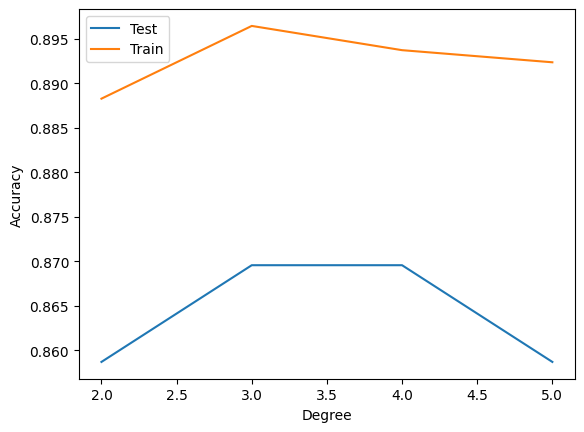

In [26]:
# LOGISTIC REGRESSION

list_accuracy_test = []
list_accuracy_train = []

# Testing model for multiple degrees
for d in range (2, 6):
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.fit_transform(X_test)
    print(len(X_poly_train), "features") # Number of features
    
    # Models w/ and w/o penalty
    model_no_reg = LogisticRegression(penalty=None, max_iter=15000, random_state=42)
    model_reg = LogisticRegression(penalty='l2', C=1, max_iter=15000, random_state=42)
    model_no_reg.fit(X_poly_train, y_train)
    model_reg.fit(X_poly_train, y_train)

    coef_no_reg = model_no_reg.coef_[0]
    intercept_no_reg = model_no_reg.intercept_

    coef_reg = model_reg.coef_[0]
    intercept_reg = model_reg.intercept_

    # Predictions
    y_train_pred_no_reg = model_no_reg.predict(X_poly_train)
    y_pred_no_reg = model_no_reg.predict(X_poly_test)
    y_train_pred_reg = model_reg.predict(X_poly_train)
    y_pred_reg = model_reg.predict(X_poly_test)


    # Results
    print("Degree", d, "Accuracy test (No Reg):", accuracy_score(y_test, y_pred_no_reg))
    print("Degree", d, "Accuracy train (No Reg):", accuracy_score(y_train, y_train_pred_no_reg))

    print("Degree", d, "Accuracy test (Reg):", accuracy_score(y_test, y_pred_reg))
    print("Degree", d, "Accuracy train (No Reg):", accuracy_score(y_train, y_train_pred_reg))

    max_accu_test = max(accuracy_score(y_test, y_pred_no_reg), accuracy_score(y_test, y_pred_reg))
    max_accu_train = max(accuracy_score(y_train, y_train_pred_no_reg), accuracy_score(y_train, y_train_pred_reg))

    list_accuracy_test.append(max_accu_test)
    list_accuracy_train.append(max_accu_train)

# Plot
plt.plot(range(2, 6), list_accuracy_test)
plt.plot(range(2, 6), list_accuracy_train)
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.legend(['Test', 'Train'])
plt.show()

d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\dev\IA01_project\IA01Proj\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

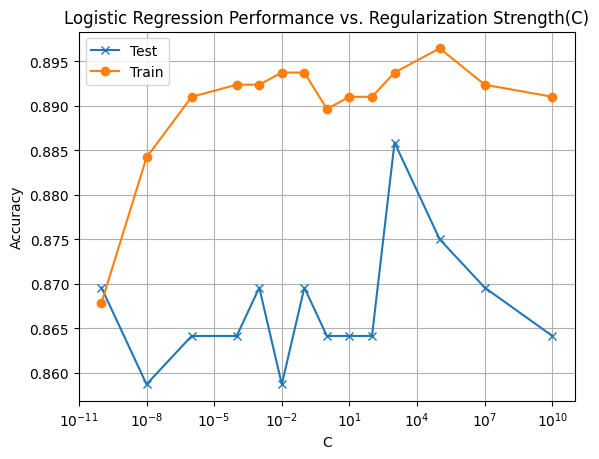

In [27]:
# Testing different Regularization parameters (C)

# Get best dregree from previous test
best_degree = np.argmax(list_accuracy_test) + 2

poly = PolynomialFeatures(degree=best_degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

C_values = [1e-10, 1e-8, 1e-6, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10e4, 10e6,
10e9]
list_accuracy_test = []
list_accuracy_train = []
list_precision = []
list_recall = []
for c in C_values:
  model_reg = LogisticRegression(penalty='l2', C=c, max_iter=15000, random_state=42)

  model_reg.fit(X_poly_train, y_train)

  coef_reg = model_reg.coef_[0]
  intercept_reg = model_reg.intercept_

  y_train_pred_reg = model_reg.predict(X_poly_train)
  y_pred_reg = model_reg.predict(X_poly_test)

  list_accuracy_train.append(accuracy_score(y_train, y_train_pred_reg))
  list_accuracy_test.append(accuracy_score(y_test, y_pred_reg))
  list_precision.append(precision_score(y_test, y_pred_reg))
  list_recall.append(recall_score(y_test, y_pred_reg))

# Plot
plt.figure()
plt.semilogx(C_values, list_accuracy_test, marker='x', label='Test')
plt.semilogx(C_values, list_accuracy_train, marker='o', label='Train')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance vs. Regularization Strength(C)')
plt.legend()
plt.grid(True)
plt.show()

# Index of best C value according to the graph and our analysis
index = 10 # 1000

# Results append
precision.append(list_precision[index])
recall.append(list_recall[index])
accuracy.append(list_accuracy_test[index])

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_254 (Dense)           (734, 1)                  15        
                                                                 
 dense_255 (Dense)           (734, 1)                  2         
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/10
17/17 [==============================] - 1s 9ms/step - loss: 0.5611 - accuracy: 0.8031 - val_loss: 0.5532 - val_accuracy: 0.7964
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.5520 - accuracy: 0.8109 - val_loss: 0.5481 - v

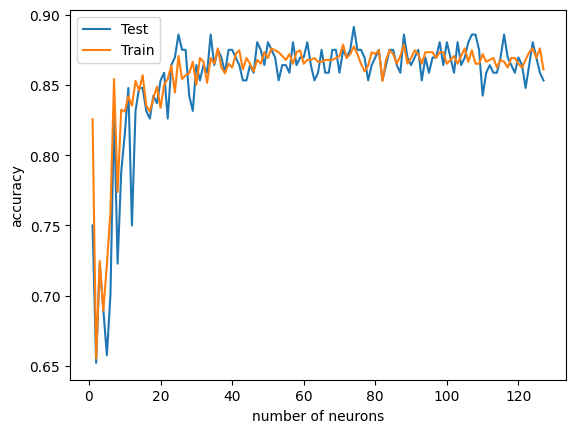

Best index: 74


In [28]:
# NEURAL NETWORK

# Building the model
set_random_seed(42)

accuracy_test = []
accuracy_train = []
list_precision = []
list_recall = []
for i in range(1, 128):
    model = Sequential()
    model.add(Dense(units=i, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.build(input_shape=X_train_scaled.shape)

    print(model.summary())
    from keras.utils import plot_model
    plot_model(model, to_file='NN-mnist.png', show_shapes=True)

    # Compiling the model
    from keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

    from keras.callbacks import EarlyStopping
    early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.3, callbacks=[early_stopping_monitor])

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    accuracy_test.append(test_acc)

    # Evaluate the model on the train set
    train_loss, train_acc = model.evaluate(X_train_scaled, y_train)
    print(f'Train accuracy: {train_acc}')
    print(f'Train loss: {train_loss}')
    accuracy_train.append(train_acc)

    y_pred = model.predict(X_test_scaled)
    # Recall (we add .round() because we want to round the values to 0 or 1)
    list_precision.append(precision_score(y_test, y_pred.round()))

    # Precision (we add .round() because we want to round the values to 0 or 1)
    list_recall.append(recall_score(y_test, y_pred.round()))
    
# print max accuracy and index
print(max(accuracy_test)) # 0.89
print(accuracy_test.index(max(accuracy_test))) # 74 neurons

# plot accuracy
plt.plot(range(1, 128), accuracy_test)
plt.xlabel('number of neurons')
plt.ylabel('accuracy')

# print max accuracy and index
print(max(accuracy_train)) # 0.88
print(accuracy_train.index(max(accuracy_train))) # 70 neurons

# plot accuracy
plt.plot(range(1, 128), accuracy_train)
plt.legend(['Test', 'Train'])
plt.show()

# Best index according to the test accuracy (and with a strong train accuracy)
best_index = accuracy_test.index(max(accuracy_test)) + 1

print("Best index:", best_index)

# Results append
precision.append(list_precision[best_index])
recall.append(list_recall[best_index])
accuracy.append(accuracy_test[best_index])

Naive Bayes model accuracy: 84.24%
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        77
           1       0.90      0.82      0.86       107

    accuracy                           0.84       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184



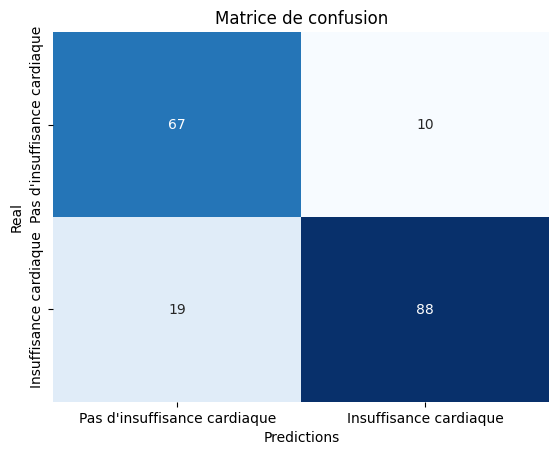

In [29]:
# NAIVE BAYES CLASSIFIER

# Scale for Bayes
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.fit_transform(X_test)

# Model fitting
bayes_model = MultinomialNB(force_alpha=True)
bayes_model.fit(X_train_minmax, y_train)

# Predictions
y_test_proba = bayes_model.predict(X_test_minmax)

# Results
accuracy_test = accuracy_score(y_test, y_test_proba)
print('Naive Bayes model accuracy:','{:2.2%}'.format(accuracy_test))
print(classification_report(y_test, y_test_proba))
conf_matrix = confusion_matrix(y_test, y_test_proba)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pas d'insuffisance cardiaque", "Insuffisance cardiaque"],
            yticklabels=["Pas d'insuffisance cardiaque", "Insuffisance cardiaque"])

# Results append
precision.append(precision_score(y_test, y_test_proba))
recall.append(recall_score(y_test, y_test_proba))
accuracy.append(accuracy_test)

# Plot
plt.title("Matrice de confusion")
plt.xlabel("Predictions")
plt.ylabel("Real")
plt.show()

Models: ['kNN', 'Random Forest', 'Logistic Regression', 'Neural network', 'Naive Bayes']
Precision: [0.9191919191919192, 0.9047619047619048, 0.9387755102040817, 0.8962264150943396, 0.8979591836734694]
Recall: [0.8504672897196262, 0.8878504672897196, 0.8598130841121495, 0.8878504672897196, 0.822429906542056]
Accuracy: [0.8695652173913043, 0.8804347826086957, 0.8858695652173914, 0.875, 0.842391304347826]


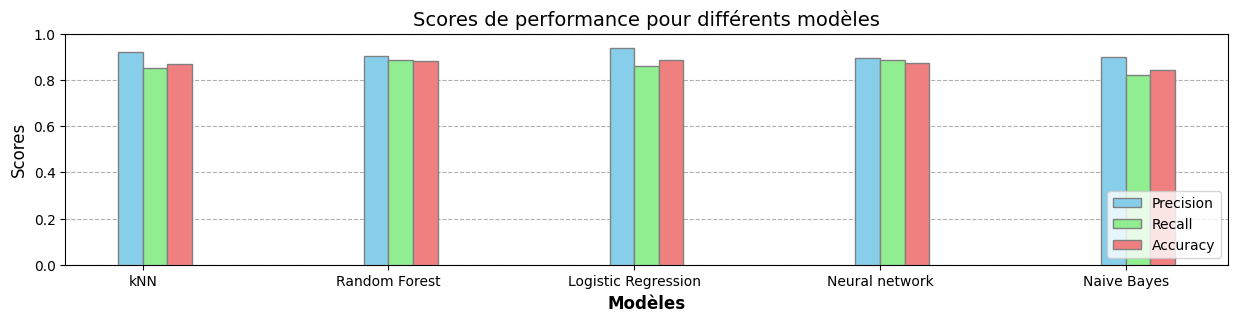

In [30]:
# RESULTS REPORT

bar_width = 0.1

models = ["kNN", "Random Forest", "Logistic Regression", "Neural network", "Naive Bayes"]
print("Models:", models)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(15, 3))

plt.bar(r1, precision, color='skyblue', width=bar_width, edgecolor='grey', label='Precision', align='edge', zorder=3)
plt.bar(r2, recall, color='lightgreen', width=bar_width, edgecolor='grey', label='Recall', align='edge', zorder=3)
plt.bar(r3, accuracy, color='lightcoral', width=bar_width, edgecolor='grey', label='Accuracy', align='edge', zorder=3)

plt.xlabel('Modèles', fontweight='bold', fontsize=12)
plt.xticks([r + bar_width for r in range(len(models))], models, fontsize=10)
plt.ylim(0, 1)  # Assurez-vous que l'axe y va de 0 à 1 pour les métriques de classification
plt.ylabel('Scores', fontsize=12)
plt.title('Scores de performance pour différents modèles', fontsize=14)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', linewidth = 0.8, zorder=0)

plt.show()